# Autoencoder Example - MIAE Introduction to Neural Networks in Engineering
March 18th, 2023

Autoencoder examples in variations (shallow, deep, CNN) 

Ilhan Esmail

Process: Encoder ---> latent space --> Decoder

Check out these additional links to learn more about [autoencoders](https://en.wikipedia.org/wiki/Autoencoder).

![From Keras blog](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Autoencoders perform data compression but not in the way JPEG or MPEG methods work (which make assumptions about images, sound, and video and apply compression based on the assumptions). Instead, autoencoders **learn** (automatically) a lossy compression based on the data examples fed in. Hence, the compression is specific to those examples, and they learn the unique features of the data.

## Elements of autoencoders

Autoencoders require 3 things:

1. Encoding function - transforming data into a compressed description
2. Decoding function - moving from compressed description back to full representation 
3. Loss function: This describes the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (hence the reference to a "loss" function).

The encoding and decoding functions are neural networks

## What Are They Good For

1. Dimension Reduction, such as in modeling/simulation of materials
2. Data Visualization and Analysis 
3. Data Denoising

## Here we focus on three versions of an autoencoder:

* VARIATION 1: Shallow Autoencoder
* VARIATION 2: Deep Autoencoder
* VARIATION 3: Convolution Autoencoder

# Data Loading and Preprocessing

We use the [MNIST data set](http://yann.lecun.com/exdb/mnist/). We start with inputing some key elements:

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#comment this out if you would like to use the GPU

from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))

else:
   print("You should install GPU version of TF for better performance")
print(tf.__version__)

print ( tf.test.gpu_device_name())

Default GPU Device:  /device:GPU:0
2.11.0
/device:GPU:0


We start by loading and scaling the input data like we did yesterday

In [2]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# MNIST contains black and white images with pixel values ranging from 0 to 255. This code scales the training and test data to range between 0 and 1.
max_value = x_train.max()
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

11490434/11490434 [==============================] - 0s 0us/step


The data set consists 3D arrays with 60K training and 10K test images. The images have a resolution of 28 x 28 (pixels) each. You can easily adapt this by loading your own dataset.

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

To work with the images as vectors, let's reshape the 3D arrays as matrices. In doing so, we'll reshape the 28 x 28 images into vectors of length 784

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

We have 60,000 row vectors of length 784 for training and 10,000 row vectors of length 784 for testing. Lets visualize a few of these digits

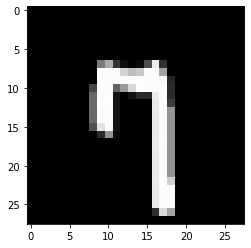

In [5]:
plt.imshow(x_test[80].reshape(28, 28))
plt.gray()

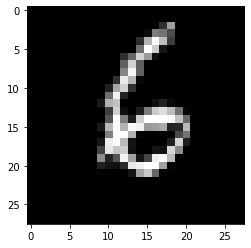

In [6]:
plt.imshow(x_test[2000].reshape(28, 28))
plt.gray()

***

# VARIATION 1: Shallow Autoencoder

We start with a simple autoencoder for illustration. The encoder and decoder functions are each fully-connected neural layers. The encoder function uses a [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), while the decoder function uses a [sigmoid activation function](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions).

So what are the encoder and the decoder layers doing?

* The encoder layer "encodes" the input image as a compressed representation in a reduced dimension. The compressed image typically looks garbled, nothing like the original image.
* The decoder layer "decodes" the encoded image back to the original dimension. The decoded image is a [lossy reconstruction](https://en.wikipedia.org/wiki/Lossy_compression) of the original image.

In our example, the compressed image has a dimension of 2 (but you can change that...). The encoder model reduces the dimension from the original 784(=28x28)-dimensional vector to the encoded 2-dimensional vector. The decoder model restores the dimension from the encoded lower-dimensional representation back to the original 784-dimensional vector.

The compression factor is the ratio of the input dimension to the encoded dimension. In our case, the factor is `392.0 = 784 / 2`.

The `autoencoder` model maps an input image to its reconstructed image.

Make sure to only enter this once! If you run this cell multiple times, you will be stacking NN layers to the currently existing network! Restart runtime if this happens (ctrl+m)

In [7]:
# input dimension = 784
input_dim = x_train.shape[1]

#encoding_dim = 32
encoding_dim = 2

#training epochs - increase for better results...but not too much! We dont want to over-fit :)
itrain_epochs = 100

compression_factor = float(input_dim) / encoding_dim
print(f"Compression factor: {compression_factor}")

#building our network in two layers
autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 392.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


## Encoder Model

We can extract the encoder model from the first layer of the autoencoder model. The reason we want to extract the encoder model is to examine what an encoded image looks like.

Input() is used to initiate a Keras tensor. We need to specify the shape of the tensor.

In [8]:
input_img = Input(shape=(input_dim,))

#Code to extract the first layer of the neural network (index=0) which is the one with 2 neurons
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


Now we are ready to train our first autoencoder. We'll iterate on the training data in batches over the epochs. We will also use [the Adam optimizer](https://arxiv.org/abs/1412.6980) and per-pixel binary [crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. The purpose of the loss function is to reconstruct an image similar to the input image.

Notice the repeat of `x_train` in `autoencoder.fit(x_train, x_train, ...)`. This implies that `x_train` is both the input and output, which is exactly what we want for image reconstruction.

The parameter `shuffle=True` means that the digits are reindexed randomly, which can often help training. So duirng training the same digit will not be at the index it was at before.

Instead of what we did yesterday where we had a validation/test code after training, we will ask the model to test its accuracy against unseen digits using `validation_data`. Here I put x_test, x_test to compare to our x_train, x_train

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=itrain_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 7s 5ms/step - loss: 0.3883 - val_loss: 0.2806
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.2732 - val_loss: 0.2638
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2575 - val_loss: 0.2513
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2505 - val_loss: 0.2476
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2474 - val_loss: 0.2450
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.2452 - val_loss: 0.2431
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2436 - val_loss: 0.2417
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2422 - val_loss: 0.2403
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2411 - val_loss: 0.2392
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2401 - val_lo

Here is where the array of floating point numbers are stores. These are the values of our neurons.

In [10]:
encoded_imgs = encoder.predict(x_test)
encoded_imgs

313/313 [==============================] - 0s 1ms/step


array([[ 3.9234293,  0.       ],
       [ 3.0321233, 15.430609 ],
       [ 8.7034   ,  8.909695 ],
       ...,
       [ 4.0342636,  5.2744856],
       [ 4.800109 , 12.227486 ],
       [ 0.       , 16.365747 ]], dtype=float32)

In [11]:
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs

313/313 [==============================] - 0s 1ms/step


array([[1.22728053e-07, 1.91959998e-07, 1.18900950e-07, ...,
        1.74858428e-07, 3.98167330e-08, 7.59527623e-08],
       [2.33262529e-19, 1.63328177e-18, 1.85510400e-19, ...,
        1.02497883e-18, 2.40458476e-21, 3.67228125e-20],
       [1.99631801e-20, 1.45777736e-19, 1.64326699e-20, ...,
        9.29568835e-20, 1.62295005e-22, 2.72287097e-21],
       ...,
       [4.07328208e-12, 1.12134503e-11, 3.67465737e-12, ...,
        8.89360894e-12, 3.55857623e-13, 1.49185200e-12],
       [1.00190763e-18, 6.28954389e-18, 8.18063893e-19, ...,
        4.08781575e-18, 1.27315035e-20, 1.68884651e-19],
       [1.10699140e-16, 5.80517895e-16, 8.94204477e-17, ...,
        3.85679988e-16, 2.40227808e-18, 2.40746269e-17]], dtype=float32)

We've successfully trained our first autoencoder. The autoencoder model can compress an MNIST digit down to a set of floating-point digits.  

To check out the encoded images and the reconstructed image quality, we randomly sample 10 test images.

Random number pair  1 image ID:  7270 [9.266597 8.686565]
Random number pair  2 image ID:  860 [ 0.25958824 11.589197  ]
Random number pair  3 image ID:  5390 [ 1.2503405 16.85436  ]
Random number pair  4 image ID:  5191 [0.       6.929366]
Random number pair  5 image ID:  5734 [3.4560456 2.1507359]
Random number pair  6 image ID:  6265 [2.9102714 6.519603 ]
Random number pair  7 image ID:  466 [ 4.5617375 12.711863 ]
Random number pair  8 image ID:  4426 [6.1355925 2.3494387]
Random number pair  9 image ID:  5578 [ 3.1104453 12.740427 ]
Random number pair  10 image ID:  8322 [2.2587223 5.8577185]


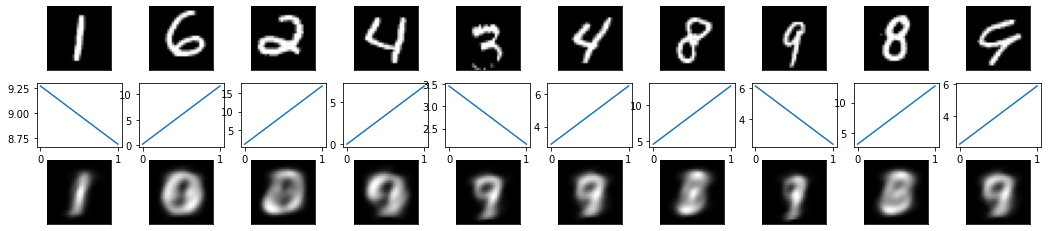

In [12]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

plt.figure(figsize=(18, 4))

# enumerate returns the index and the value
for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image. Image lies on index 11, 12, 13 and so on
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.plot (encoded_imgs[image_idx].reshape(encoding_dim, 1))
    print ("Random number pair ", i+1, "image ID: ", image_idx, encoded_imgs[image_idx])
    plt.gray()
  

    # plot reconstructed image. Image lies on index 21, 22, 23, and so on
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Notice two things from this exercise. Using a shallow neural network doesn't give us the type of accuracy and precision that we're looking for. Granted if we increase the number of neurons we will surely get a better result. But lets explore how the architecture of a neural network can help us with better autoecoders.

***

# VARIATION 2: Deep Autoencoder


Above, we used single fully-connected layers for both the encoding and decoding models. Instead, we can stack multiple fully-connected layers to make each of the encoder and decoder functions **deep**.  

We will now use **3 fully-connected layers** for the encoding model with decreasing dimensions from 784->16->8 and `encoding_dim=2`. Likewise, we'll add 3 fully-connected decoder layers that reconstruct the image back to 784 dimensions. Except for the last layer, we'll use ReLU activation functions again.

In Keras, this is simple to do, and you can use this example for your applications. We can use the same training configuration as above (or a variation thereof - e.g. Adam + 50 epochs + batch size of 256 works well).

In [18]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(8 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(2*encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(8 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                12560     
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 8)                 40        
                                                                 
 dense_12 (Dense)            (None, 16)                144       
                                                                 
 dense_13 (Dense)            (None, 784)               13328     
                                                                 
Total params: 26,244
Trainable params: 26,244
Non-trai

## Encoder Model

Like we did above, we can extract the encoder model from the autoencoder. The encoder model consists of the first 3 layers in the autoencoder, so let's extract them to visualize the encoded images.

In [19]:
#Getting the encoder.... 

input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 16)                12560     
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
Total params: 12,732
Trainable params: 12,732
Non-trainable params: 0
_________________________________________________________________


And here we run our training once again. Keeping all the previous parameters the same but since its a deep learning model, it will take longer to learn (around 8 minutes).

In [20]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=itrain_epochs,
                batch_size=128,
                validation_data=(x_test, x_test))

Epoch 1/100
469/469 [==============================] - 4s 5ms/step - loss: 0.2948 - val_loss: 0.2441
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2403 - val_loss: 0.2363
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2348 - val_loss: 0.2304
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2288 - val_loss: 0.2253
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2250 - val_loss: 0.2219
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2222 - val_loss: 0.2194
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2199 - val_loss: 0.2173
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2154 - val_loss: 0.2089
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2065 - val_loss: 0.2038
Epoch 10/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2034 - val_lo

313/313 [==============================] - 1s 2ms/step
Random number pair  0 image ID:  7270 [86.79593  78.63428  60.511734  0.      ]
Random number pair  1 image ID:  860 [ 6.9039583 21.613638  28.667242   0.       ]
Random number pair  2 image ID:  5390 [ 2.8614116  4.1793594 12.807213   0.       ]
Random number pair  3 image ID:  5191 [ 9.571408 31.574362 34.128147  0.      ]
Random number pair  4 image ID:  5734 [22.716326 48.991505 44.125877  0.      ]
Random number pair  5 image ID:  6265 [10.357501 24.419882 40.830097  0.      ]
Random number pair  6 image ID:  466 [ 6.3286886  7.1509104 16.026382   0.       ]
Random number pair  7 image ID:  4426 [26.59789 46.09193 54.00008  0.     ]
Random number pair  8 image ID:  5578 [ 4.319116  8.842619 13.34452   0.      ]
Random number pair  9 image ID:  8322 [ 9.270553 24.494617 35.738205  0.      ]


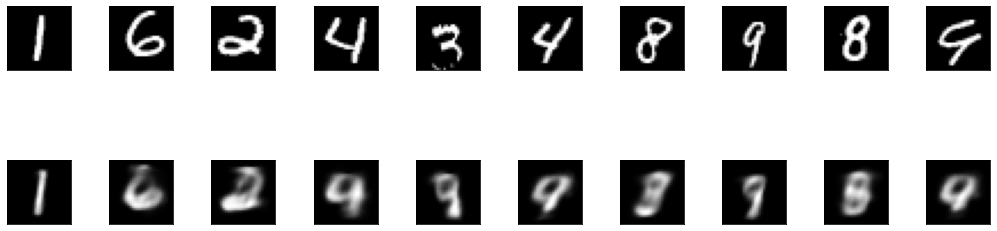

In [21]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print ("Random number pair ", i, "image ID: ", image_idx, encoded_imgs[image_idx])
    
    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As with the shallow autoencoder, we randomly sample 10 test images. The reconstructed digits look much better than those from the single-layer autoencoder. We can see that the validation loss is lower after each training epoch compared to the shallow autoencoder model.

***

# VARIATION 3: Convolutional Autoencoder

Now that we've explored deep autoencoders, let us now use a convolutional autoencoder instead, given that the input objects are images (so now we have a deep, convolutional NN). What this means is our encoding and decoding models will be [convolutional neural networks](http://cs231n.github.io/convolutional-networks/) instead of fully-connected networks.

Keras makes this very easy for us. Before we get started though, we need to reshape the images back to `28 x 28 x 1` for the convolutional layers. The 1 is for 1 channel because black and white. If we had RGB color, there would be 3 channels. We now use a latent space dimension of 128.

In [24]:
itrain_epochs = 25

x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

This part can get a little tricky. To build the convolutional autoencoder, we'll make use of `Conv2D` and `MaxPooling2D` layers for the encoder and `Conv2D` and `UpSampling2D` layers for the decoder. 

The first entry of the `conv2D` is the filter size. The (3,3) is an two dimensional array of weights (so 9 in total). 9 times 16 filter is 144 plus 16 biases for each filter so 160 parameters in total.

The MaxPool2D step takes our array of 28x28 images and reduces it, in this case to 14 by 14 but keeping the same number of filters.

The encoded images are transformed to a 3D array of dimensions `4 x 4 x 8`, but to visualize the encoding, we'll flatten it to a vector of length 128. 



After the flattening layer, we reshape the image back to a `4 x 4 x 8` array before upsampling back to a `28 x 28 x 1` image.

In [25]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# The final Conv2D layer of the encoder shapes our image as a 4,4,8. To make it easier for us to visualize the encoding lets flatten encoding to 1, 128.
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers - this will take our compressed representation created by the encoder and attempt to recreate the image in our orignial 28x28 representation.
# Notice how this is exactly the same as the encoder but in the reverse direction. And finally, the last layer is of fully connected layer (FC) which will give us our class score (the number from 0-9)
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)              

Notice how we only have 4,385 parameters versus our deep neural network with 26,210 parameters. CNNs are far more efficient for image recognition

## Encoder Model

To extract the encoder model for the autoencoder, we're going to use a slightly different approach than before. Rather than extracting the first 6 layers, we're going to create a new `Model` with the same input as the autoencoder, but the output will be that of the flattening layer. As a side note, this is a very useful technique for grabbing submodels for things like [transfer learning](http://ruder.io/transfer-learning/).

As I mentioned before, the encoded image is a vector of length 128.

In [26]:
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten').output)

encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           584 

I recommend you use a GPU for this step. It will reduce the training time from 26 miutes to 6 minutes

In [27]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=itrain_epochs,
                batch_size=32,
                validation_data=(x_test, x_test))

Epoch 1/25
1875/1875 [==============================] - 19s 6ms/step - loss: 0.1477 - val_loss: 0.1104
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1040 - val_loss: 0.0987
Epoch 3/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0961 - val_loss: 0.0925
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0921 - val_loss: 0.0897
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0898 - val_loss: 0.0882
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0882 - val_loss: 0.0867
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0870 - val_loss: 0.0858
Epoch 8/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0861 - val_loss: 0.0843
Epoch 9/25
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0852 - val_loss: 0.0841
Epoch 10/25
1875/1875 [==============================] - 16s 9ms/step - l

The reconstructed digits look even better than before. This is no surprise given an even lower validation loss. Other than slight improved reconstruction, check out how the encoded image has changed. What's even cooler is that the encoded images of the 9 look similar as do those of the 8's. This similarity was far less pronounced for the simple and deep autoencoders.

313/313 [==============================] - 2s 6ms/step


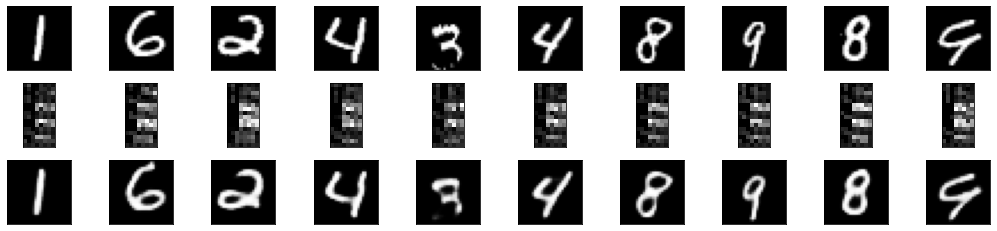

In [28]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    #print (encoded_imgs[image_idx])
    
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()